# 03 - Inference Pipeline

This notebook demonstrates the end-to-end facial keypoint detection pipeline.

## Overview

- Use `FacialKeypointsPipeline` for complete face detection + keypoint prediction
- Process images with multiple faces
- Visualize results with bounding boxes and keypoints
- Explore individual pipeline components

## Prerequisites

- Trained model from `02_model_training.ipynb` (saved in `models/`)
- Haar cascade file in `detector_architectures/`

In [1]:
# Standard imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Package imports
from facial_keypoints.pipeline import FacialKeypointsPipeline
from facial_keypoints.detection.face_detector import FaceDetector
from facial_keypoints.models.predictor import KeypointPredictor
from facial_keypoints.visualization.plotting import (
    plot_keypoints,
    plot_face_detections,
    plot_pipeline_result,
)

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

# Set paths relative to notebook location
PROJECT_ROOT = Path('..').resolve()
print(f"Project root: {PROJECT_ROOT}")

2026-01-14 18:21:56.132701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Project root: /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection


## 1. Check Prerequisites

Verify that required files exist before initializing the pipeline.

In [2]:
# Check for required files
cascade_path = PROJECT_ROOT / 'detector_architectures' / 'haarcascade_frontalface_default.xml'
model_path = PROJECT_ROOT / 'models' / 'model.keras'
best_model_path = PROJECT_ROOT / 'models' / 'best_model.keras'
images_dir = PROJECT_ROOT / 'images'

print("File Availability Check")
print("=" * 50)
print(f"Haar Cascade:  {'OK' if cascade_path.exists() else 'MISSING'} - {cascade_path}")
print(f"Trained Model: {'OK' if model_path.exists() else 'MISSING'} - {model_path}")
print(f"Best Model:    {'OK' if best_model_path.exists() else 'MISSING'} - {best_model_path}")
print(f"Images Dir:    {'OK' if images_dir.exists() else 'MISSING'} - {images_dir}")

# Use best model if available, otherwise use model.keras
if best_model_path.exists():
    use_model_path = best_model_path
elif model_path.exists():
    use_model_path = model_path
else:
    use_model_path = None
    print("\nNo trained model found! Run 02_model_training.ipynb first.")

if use_model_path:
    print(f"\nUsing model: {use_model_path.name}")

File Availability Check
Haar Cascade:  OK - /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/detector_architectures/haarcascade_frontalface_default.xml
Trained Model: OK - /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/models/model.keras
Best Model:    OK - /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/models/best_model.keras
Images Dir:    OK - /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/images

Using model: best_model.keras


## 2. Initialize the Pipeline

The `FacialKeypointsPipeline` combines face detection (Haar Cascades) with keypoint prediction (CNN).

In [3]:
# Initialize the pipeline
if use_model_path and cascade_path.exists():
    pipeline = FacialKeypointsPipeline(
        cascade_path=str(cascade_path),
        model_path=str(use_model_path),
    )
    print("Pipeline initialized successfully!")
    print(f"  Cascade: {cascade_path.name}")
    print(f"  Model: {use_model_path.name}")
else:
    pipeline = None
    print("Cannot initialize pipeline - missing required files.")
    print("\nTo continue:")
    print("  1. Ensure haarcascade file exists in detector_architectures/")
    print("  2. Train a model using 02_model_training.ipynb")

W0000 00:00:1768407724.734048 4105089 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Pipeline initialized successfully!
  Cascade: haarcascade_frontalface_default.xml
  Model: best_model.keras


## 3. List Available Test Images

In [4]:
# List available images
if images_dir.exists():
    image_files = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png'))
    print(f"Found {len(image_files)} images in {images_dir}:")
    for img_path in image_files:
        size_kb = img_path.stat().st_size / 1024
        print(f"  - {img_path.name} ({size_kb:.1f} KB)")
else:
    print("Images directory not found")
    image_files = []

Found 11 images in /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/images:
  - test_image_1.jpg (1768.5 KB)
  - fawzia.jpg (197.7 KB)
  - gus.jpg (583.9 KB)
  - streetview_example_1.jpg (46.4 KB)
  - james.jpg (22.0 KB)
  - streetview_example_2.jpg (52.6 KB)
  - obamas4.jpg (58.8 KB)
  - obamas_with_shades.png (2005.2 KB)
  - obamas_points_numbered.png (2212.5 KB)
  - obamas_with_keypoints.png (1927.5 KB)
  - keypoints_test_results.png (1398.9 KB)


## 4. Process a Single Image

Use `pipeline.process()` to detect faces and predict keypoints in one call.

In [5]:
# Process first available image
if pipeline and image_files:
    # Select first image
    test_image_path = image_files[0]
    print(f"Processing: {test_image_path}")
    
    # Process with pipeline
    result = pipeline.process(str(test_image_path))
    
    print(f"\nResults:")
    print(f"  Image shape: {result.image.shape}")
    print(f"  Faces detected: {result.n_faces}")
    
    for i, face in enumerate(result.faces):
        box = face.bounding_box
        print(f"\n  Face {i + 1}:")
        print(f"    Bounding box: ({box.x}, {box.y}) size {box.width}x{box.height}")
        print(f"    Center: {box.center}")
        print(f"    Keypoints: {face.keypoints.shape[0]} points")
else:
    result = None
    print("Cannot process - pipeline not initialized or no images available")

Processing: /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/images/test_image_1.jpg

Results:
  Image shape: (1526, 1800, 3)
  Faces detected: 17

  Face 1:
    Bounding box: (1157, 138) size 82x82
    Center: (1198, 179)
    Keypoints: 15 points

  Face 2:
    Bounding box: (1296, 93) size 96x96
    Center: (1344, 141)
    Keypoints: 15 points

  Face 3:
    Bounding box: (918, 104) size 94x94
    Center: (965, 151)
    Keypoints: 15 points

  Face 4:
    Bounding box: (690, 155) size 83x83
    Center: (731, 196)
    Keypoints: 15 points

  Face 5:
    Bounding box: (513, 156) size 94x94
    Center: (560, 203)
    Keypoints: 15 points

  Face 6:
    Bounding box: (1563, 336) size 100x100
    Center: (1613, 386)
    Keypoints: 15 points

  Face 7:
    Bounding box: (1279, 215) size 108x108
    Center: (1333, 269)
    Keypoints: 15 points

  Face 8:
    Bounding box: (142, 454) size 107x107
    Center: (195, 507)
    Keypoints: 15 points

  Face 9:
    Bounding box: (58

## 5. Visualize Results

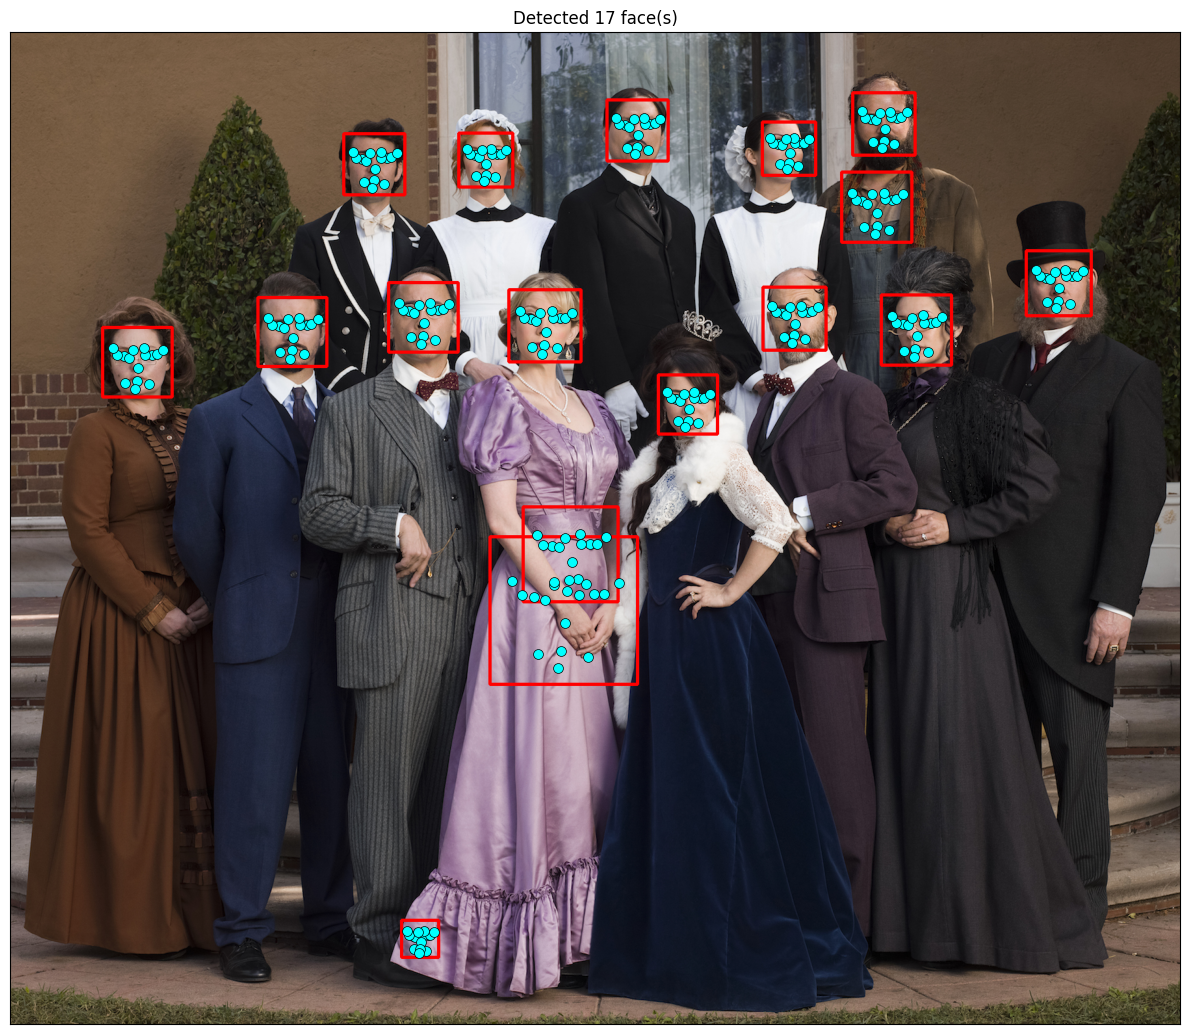

In [6]:
# Visualize the pipeline results
if result:
    fig = plot_pipeline_result(
        result.image,
        result.faces,
        figsize=(12, 12),
        show_boxes=True,
        show_keypoints=True,
        keypoint_color='cyan',
        keypoint_size=50,
    )
    plt.show()
else:
    print("No results to visualize")

## 6. Process All Test Images

In [7]:
# Process all available images
if pipeline and image_files:
    all_results = []
    
    print("Processing all images...")
    print("=" * 50)
    
    for img_path in image_files:
        try:
            res = pipeline.process(str(img_path))
            all_results.append((img_path.name, res))
            status = "OK"
            n_faces = res.n_faces
        except Exception as e:
            status = f"ERROR: {e}"
            n_faces = 0
        
        print(f"{img_path.name:30s} - {n_faces} face(s) - {status}")
    
    print(f"\nProcessed {len(all_results)} images")
    total_faces = sum(r.n_faces for _, r in all_results)
    print(f"Total faces detected: {total_faces}")
else:
    all_results = []
    print("Cannot process images")

Processing all images...
test_image_1.jpg               - 17 face(s) - OK
fawzia.jpg                     - 1 face(s) - OK
gus.jpg                        - 1 face(s) - OK
streetview_example_1.jpg       - 0 face(s) - OK
james.jpg                      - 1 face(s) - OK
streetview_example_2.jpg       - 0 face(s) - OK
obamas4.jpg                    - 2 face(s) - OK
obamas_with_shades.png         - 4 face(s) - OK
obamas_points_numbered.png     - 2 face(s) - OK
obamas_with_keypoints.png      - 4 face(s) - OK
keypoints_test_results.png     - 8 face(s) - OK

Processed 11 images
Total faces detected: 40


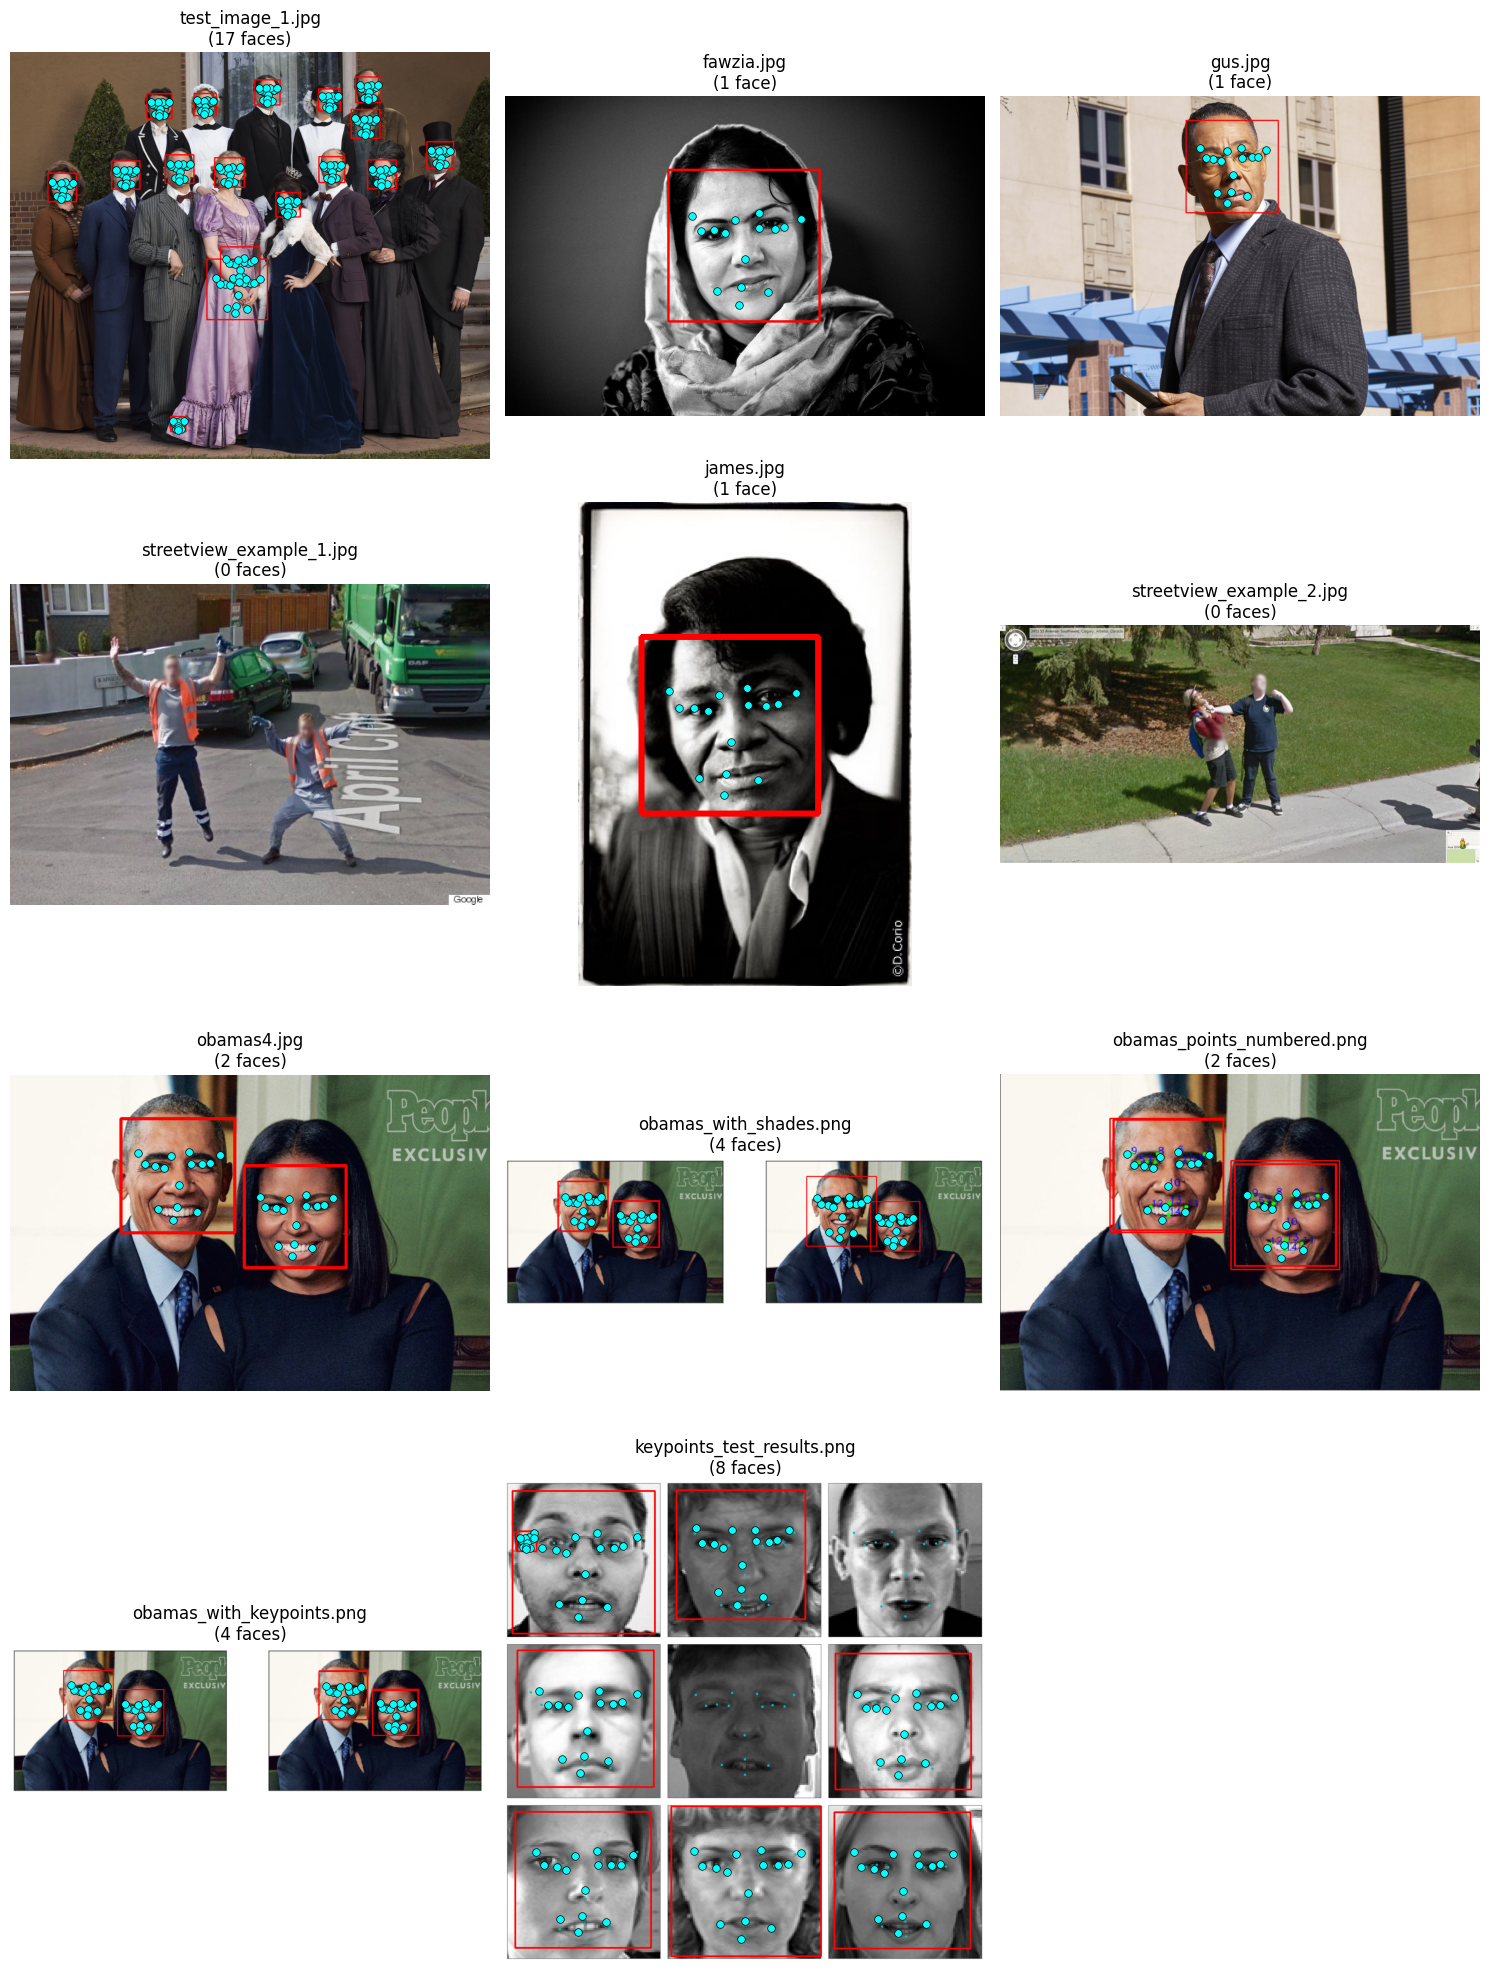

In [8]:
# Display all results in a grid
if all_results:
    n_images = len(all_results)
    n_cols = min(3, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, (name, res) in enumerate(all_results):
        ax = axes[i]
        
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(res.image.copy(), cv2.COLOR_BGR2RGB)
        
        # Draw boxes and keypoints
        for face in res.faces:
            box = face.bounding_box
            cv2.rectangle(img_rgb, (box.x, box.y), 
                          (box.x + box.width, box.y + box.height), (255, 0, 0), 3)
        
        ax.imshow(img_rgb)
        
        # Overlay keypoints
        for face in res.faces:
            ax.scatter(face.keypoints[:, 0], face.keypoints[:, 1],
                       c='cyan', s=30, marker='o', edgecolors='black', linewidths=0.5)
        
        ax.set_title(f"{name}\n({res.n_faces} face{'s' if res.n_faces != 1 else ''})")
        ax.axis('off')
    
    # Hide unused axes
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 7. Using Individual Components

You can also use `FaceDetector` and `KeypointPredictor` separately for more control.

FaceDetector Results
Image: test_image_1.jpg
Detected 17 face(s):

Face 1:
  Position: (1157, 138)
  Size: 82 x 82
  Area: 6724 pixels
  Center: (1198, 179)
Face 2:
  Position: (1563, 336)
  Size: 100 x 100
  Area: 10000 pixels
  Center: (1613, 386)
Face 3:
  Position: (690, 155)
  Size: 83 x 83
  Area: 6889 pixels
  Center: (731, 196)
Face 4:
  Position: (1296, 93)
  Size: 96 x 96
  Area: 9216 pixels
  Center: (1344, 141)
Face 5:
  Position: (582, 385)
  Size: 107 x 107
  Area: 11449 pixels
  Center: (635, 438)
Face 6:
  Position: (1158, 392)
  Size: 97 x 97
  Area: 9409 pixels
  Center: (1206, 440)
Face 7:
  Position: (918, 104)
  Size: 94 x 94
  Area: 8836 pixels
  Center: (965, 151)
Face 8:
  Position: (513, 156)
  Size: 94 x 94
  Area: 8836 pixels
  Center: (560, 203)
Face 9:
  Position: (142, 454)
  Size: 107 x 107
  Area: 11449 pixels
  Center: (195, 507)
Face 10:
  Position: (381, 408)
  Size: 106 x 106
  Area: 11236 pixels
  Center: (434, 461)
Face 11:
  Position: (1340, 404)


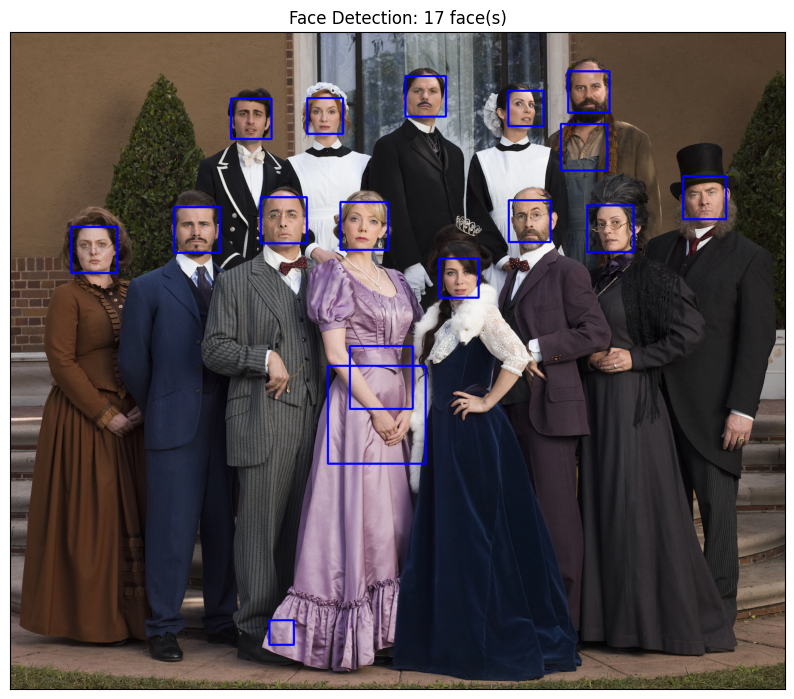

In [9]:
# Use FaceDetector independently
if cascade_path.exists() and image_files:
    detector = FaceDetector(
        cascade_path=str(cascade_path),
        scale_factor=1.2,
        min_neighbors=5,
    )
    
    # Load first image
    test_img = cv2.imread(str(image_files[0]))
    
    # Detect faces
    boxes = detector.detect(test_img)
    
    print(f"FaceDetector Results")
    print("=" * 40)
    print(f"Image: {image_files[0].name}")
    print(f"Detected {len(boxes)} face(s):\n")
    
    for i, box in enumerate(boxes):
        print(f"Face {i + 1}:")
        print(f"  Position: ({box.x}, {box.y})")
        print(f"  Size: {box.width} x {box.height}")
        print(f"  Area: {box.area} pixels")
        print(f"  Center: {box.center}")
    
    # Visualize
    fig = plot_face_detections(test_img, boxes, title=f"Face Detection: {len(boxes)} face(s)")
    plt.show()
else:
    boxes = []
    print("Cannot run detector - missing cascade file or images")

KeypointPredictor Results
Raw output shape: (30,)
Keypoints shape: (15, 2)

Keypoint coordinates (in 96x96 space):
   0. left_eye_center     : ( 67.90,  37.56)
   1. right_eye_center    : ( 28.87,  39.41)
   2. left_eye_inner      : ( 58.80,  37.63)
   3. left_eye_outer      : ( 74.55,  37.09)
   4. right_eye_inner     : ( 35.46,  41.63)
   5. right_eye_outer     : ( 19.79,  37.88)
   6. left_eyebrow_in     : ( 57.53,  28.00)
   7. left_eyebrow_out    : ( 83.42,  29.90)
   8. right_eyebrow_in    : ( 41.81,  30.75)
   9. right_eyebrow_out   : ( 14.23,  28.39)
  10. nose_tip            : ( 49.13,  55.50)
  11. mouth_left          : ( 63.82,  78.29)
  12. mouth_right         : ( 31.26,  75.80)
  13. mouth_top           : ( 47.29,  73.94)
  14. mouth_bottom        : ( 44.44,  85.16)


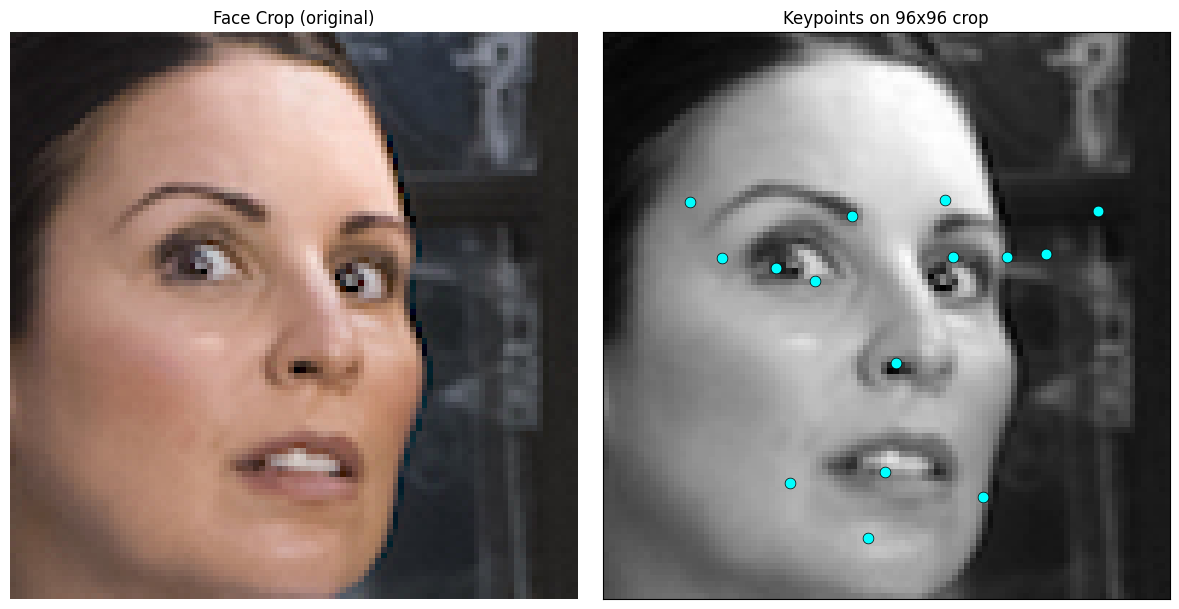

In [10]:
# Use KeypointPredictor independently
if use_model_path and boxes:
    predictor = KeypointPredictor(
        model_path=str(use_model_path),
        image_size=96,
    )
    
    # Get first face crop
    box = boxes[0]
    face_crop = detector.crop_face(test_img, box, padding=0.1)
    
    # Predict keypoints
    prediction = predictor.predict(face_crop, denormalize=True)
    
    print("KeypointPredictor Results")
    print("=" * 40)
    print(f"Raw output shape: {prediction.raw_output.shape}")
    print(f"Keypoints shape: {prediction.keypoints.shape}")
    print(f"\nKeypoint coordinates (in 96x96 space):")
    
    KEYPOINT_NAMES = [
        'left_eye_center', 'right_eye_center', 'left_eye_inner', 'left_eye_outer',
        'right_eye_inner', 'right_eye_outer', 'left_eyebrow_in', 'left_eyebrow_out',
        'right_eyebrow_in', 'right_eyebrow_out', 'nose_tip',
        'mouth_left', 'mouth_right', 'mouth_top', 'mouth_bottom'
    ]
    
    for i, ((x, y), name) in enumerate(zip(prediction.keypoints, KEYPOINT_NAMES)):
        print(f"  {i:2d}. {name:20s}: ({x:6.2f}, {y:6.2f})")
    
    # Visualize on the face crop
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original crop
    axes[0].imshow(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Face Crop (original)')
    axes[0].axis('off')
    
    # Resized with keypoints
    gray_crop = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
    gray_resized = cv2.resize(gray_crop, (96, 96))
    plot_keypoints(gray_resized, prediction.keypoints.flatten(), ax=axes[1],
                   marker_color='cyan', marker_size=60)
    axes[1].set_title('Keypoints on 96x96 crop')
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot run predictor - missing model or no faces detected")

## 8. Compare Detection Modes

Compare `detect_all=True` (all faces) vs `detect_all=False` (largest face only).

Testing detection modes on: obamas_with_keypoints.png


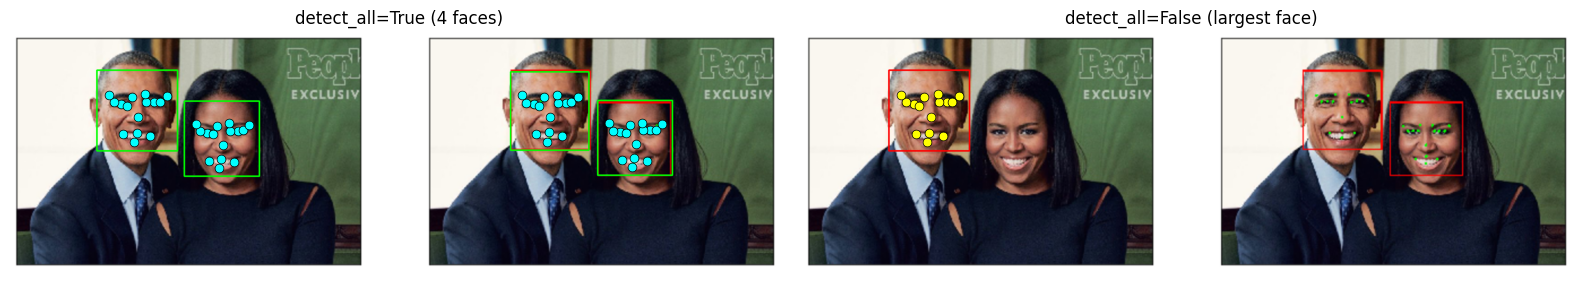

In [11]:
# Find an image with multiple faces for comparison
if pipeline and image_files:
    # Try to find image with multiple faces, or use any available
    multi_face_candidates = ['obamas.jpg', 'obamas_with_keypoints.png']
    test_path = None
    
    for candidate in multi_face_candidates:
        candidate_path = images_dir / candidate
        if candidate_path.exists():
            test_path = candidate_path
            break
    
    if test_path is None and image_files:
        test_path = image_files[0]
    
    if test_path:
        print(f"Testing detection modes on: {test_path.name}")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Detect all faces
        result_all = pipeline.process(str(test_path), detect_all=True)
        img_all = cv2.cvtColor(result_all.image.copy(), cv2.COLOR_BGR2RGB)
        for face in result_all.faces:
            box = face.bounding_box
            cv2.rectangle(img_all, (box.x, box.y),
                          (box.x + box.width, box.y + box.height), (0, 255, 0), 3)
        axes[0].imshow(img_all)
        for face in result_all.faces:
            axes[0].scatter(face.keypoints[:, 0], face.keypoints[:, 1],
                            c='cyan', s=40, edgecolors='black', linewidths=0.5)
        axes[0].set_title(f'detect_all=True ({result_all.n_faces} faces)')
        axes[0].axis('off')
        
        # Detect single (largest) face
        result_single = pipeline.process(str(test_path), detect_all=False)
        img_single = cv2.cvtColor(result_single.image.copy(), cv2.COLOR_BGR2RGB)
        for face in result_single.faces:
            box = face.bounding_box
            cv2.rectangle(img_single, (box.x, box.y),
                          (box.x + box.width, box.y + box.height), (255, 0, 0), 3)
        axes[1].imshow(img_single)
        for face in result_single.faces:
            axes[1].scatter(face.keypoints[:, 0], face.keypoints[:, 1],
                            c='yellow', s=40, edgecolors='black', linewidths=0.5)
        axes[1].set_title(f'detect_all=False (largest face)')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("Cannot run comparison - pipeline not initialized or no images")

## 9. Export Results

In [12]:
def save_annotated_image(result, output_path, draw_boxes=True, draw_keypoints=True):
    """Save processed result to an image file with annotations."""
    img = result.image.copy()
    
    for face in result.faces:
        box = face.bounding_box
        
        if draw_boxes:
            cv2.rectangle(img, (box.x, box.y),
                          (box.x + box.width, box.y + box.height), (0, 255, 0), 2)
        
        if draw_keypoints:
            for x, y in face.keypoints:
                cv2.circle(img, (int(x), int(y)), 3, (0, 255, 255), -1)
    
    cv2.imwrite(str(output_path), img)
    print(f"Saved: {output_path}")

def export_keypoints_json(result, output_path, image_name=""):
    """Export keypoints to JSON format."""
    data = {
        "image": image_name,
        "n_faces": result.n_faces,
        "faces": []
    }
    
    for i, face in enumerate(result.faces):
        face_data = {
            "face_id": i,
            "bounding_box": {
                "x": int(face.bounding_box.x),
                "y": int(face.bounding_box.y),
                "width": int(face.bounding_box.width),
                "height": int(face.bounding_box.height),
            },
            "keypoints": [
                {"x": float(x), "y": float(y)}
                for x, y in face.keypoints
            ]
        }
        data["faces"].append(face_data)
    
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"Exported: {output_path}")

# Save results
if result:
    output_dir = PROJECT_ROOT / 'output'
    output_dir.mkdir(exist_ok=True)
    
    save_annotated_image(result, output_dir / 'annotated_result.jpg')
    export_keypoints_json(result, output_dir / 'keypoints.json', 
                          image_name=image_files[0].name if image_files else "")
    
    print(f"\nOutput saved to: {output_dir}")
else:
    print("No results to export")

Saved: /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/output/annotated_result.jpg
Exported: /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/output/keypoints.json

Output saved to: /home/lpetrov/projects/courses/Udacity/Facial-Keypoint-Detection/output


## Summary

This notebook demonstrated:

1. **Pipeline Usage**: `FacialKeypointsPipeline` for end-to-end face detection + keypoint prediction
2. **Visualization**: `plot_pipeline_result()` and related functions
3. **Component Access**: Using `FaceDetector` and `KeypointPredictor` independently
4. **Batch Processing**: Processing multiple images from a directory
5. **Detection Modes**: Comparing all faces vs. single largest face
6. **Export**: Saving results as annotated images or JSON

### API Quick Reference

```python
# High-level pipeline
from facial_keypoints.pipeline import FacialKeypointsPipeline

pipeline = FacialKeypointsPipeline(cascade_path, model_path)
result = pipeline.process(image)  # Returns PipelineResult

# Result contains:
result.n_faces        # Number of detected faces
result.image          # Original image
result.faces          # List of FaceKeypointsResult

# Each face contains:
face.bounding_box     # BoundingBox with x, y, width, height
face.keypoints        # np.ndarray of shape (15, 2)

# Low-level components
from facial_keypoints.detection.face_detector import FaceDetector
from facial_keypoints.models.predictor import KeypointPredictor

detector = FaceDetector(cascade_path)
boxes = detector.detect(image)  # Returns list[BoundingBox]

predictor = KeypointPredictor(model_path)
prediction = predictor.predict(face_crop)  # Returns KeypointPrediction
```